In [129]:
import csv
import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.signal

In [114]:
def read_data(filename):
    times = []   # sec
    flows = []   # L/sec
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                times.append(float(line[1].replace(",", "")))
                flows.append(np.sign(float(line[2]))*abs(float(line[2]) / 0.0538)**(4.0/7.0) / 60.0)
            if line[0] == "Sample #":
                start_fill = True
    return collections.namedtuple("TimesFlows", ["times", "flows"])(np.array(times), np.array(flows))

first = read_data("../sample-data/Sensirion_Philippe.csv")
normal = read_data("../sample-data/Sensirion_Philippe_normal.csv")
strong = read_data("../sample-data/Sensirion_Philippe_strongl.csv")

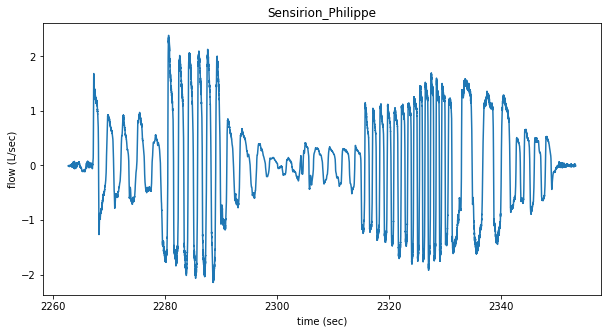

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.flows)
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe.png")

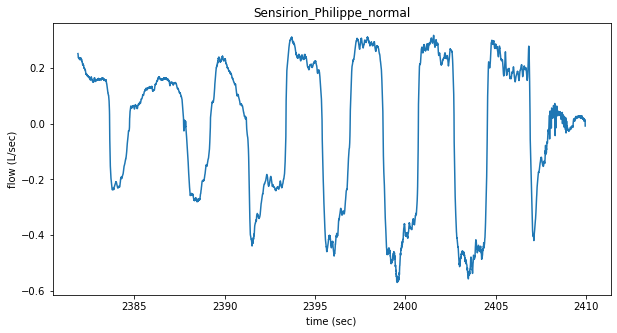

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.flows)
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_normal.png")

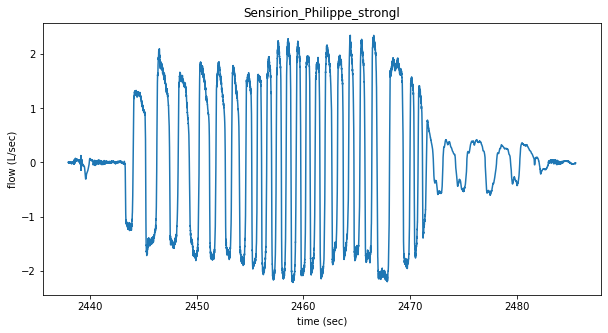

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.flows)
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_strongl.png")

In [262]:
def compute_volume(dataset):
    volumes = scipy.integrate.cumtrapz(dataset.flows, dataset.times)
    filtered = scipy.signal.sosfilt(scipy.signal.butter(1, 0.003, "highpass", output="sos"), volumes)
    return collections.namedtuple("TimesFlowsVolumes", ["times", "flows", "volumes", "filtered"])(
        dataset.times[:-1], dataset.flows[:-1], volumes, filtered)

first = compute_volume(first)
normal = compute_volume(normal)
strong = compute_volume(strong)

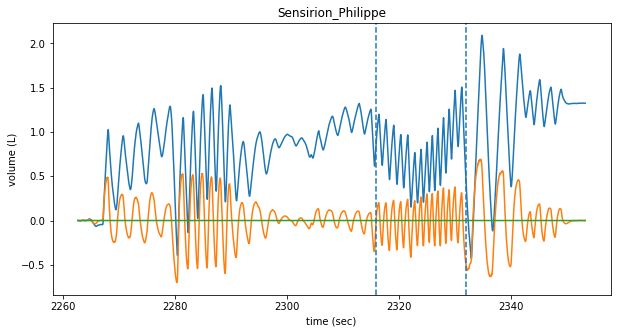

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.volumes)
ax.plot(first.times, first.filtered)
ax.plot(first.times, np.zeros(len(first.times)))
ax.axvline(2316, linestyle="--")
ax.axvline(2332, linestyle="--")
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe-volume.png")

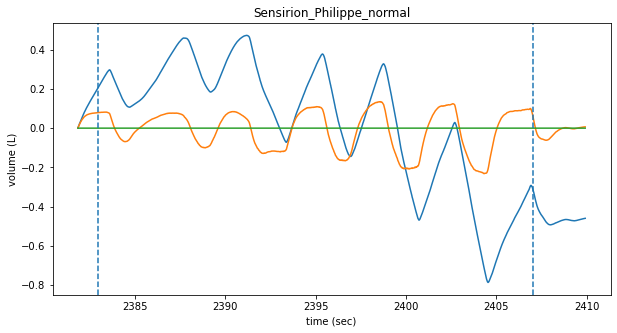

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.volumes)
ax.plot(normal.times, normal.filtered)
ax.plot(normal.times, np.zeros(len(normal.times)))
ax.axvline(2383, linestyle="--")
ax.axvline(2407, linestyle="--")
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_normal-volume.png")

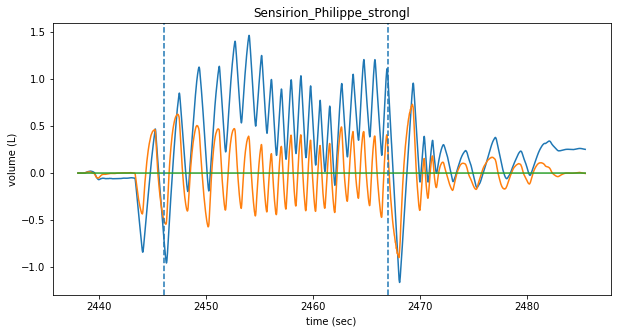

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.volumes)
ax.plot(strong.times, strong.filtered)
ax.plot(strong.times, np.zeros(len(strong.times)))
ax.axvline(2446, linestyle="--")
ax.axvline(2467, linestyle="--")
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_strongl-volume.png")

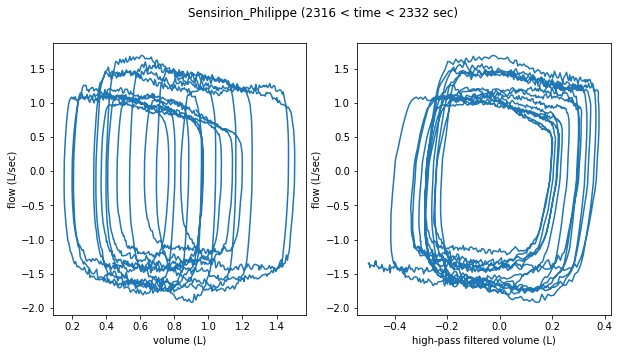

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2316 < first.times, first.times < 2332)
ax1.plot(first.volumes[timecut], first.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(first.filtered[timecut], first.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe (2316 < time < 2332 sec)")
fig.savefig("Sensirion_Philippe-phase.png")

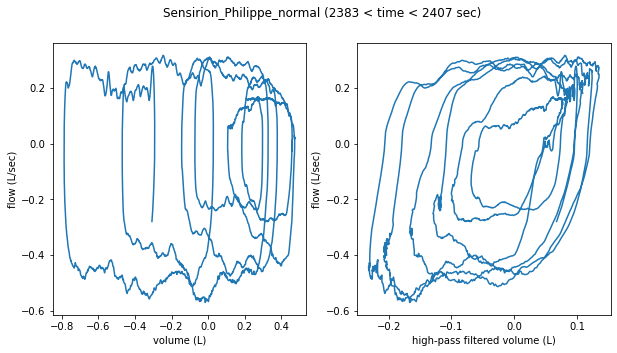

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2383 < normal.times, normal.times < 2407)
ax1.plot(normal.volumes[timecut], normal.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(normal.filtered[timecut], normal.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe_normal (2383 < time < 2407 sec)")
fig.savefig("Sensirion_Philippe_normal-phase.png")

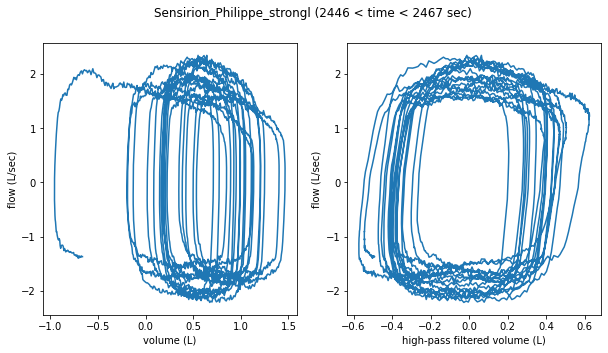

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2446 < strong.times, strong.times < 2467)
ax1.plot(strong.volumes[timecut], strong.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(strong.filtered[timecut], strong.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe_strongl (2446 < time < 2467 sec)")
fig.savefig("Sensirion_Philippe_strongl-phase.png")

In [277]:
length = 8
window = 5

dtype = np.dtype(np.int64)
np.lib.stride_tricks.as_strided(np.arange(length, dtype=dtype), (length - window + 1, window), (dtype.itemsize, dtype.itemsize))

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7]])

In [317]:
def smooth_derivative(times, values, sig):
    window_width = int(np.ceil(6*sig/np.min(times[1:] - times[:-1])))
    windowed_times  = np.lib.stride_tricks.as_strided(times,
                                                      (len(times) - window_width + 1, window_width),
                                                      (times.itemsize, times.itemsize))
    windowed_values = np.lib.stride_tricks.as_strided(values,
                                                      (len(values) - window_width + 1, window_width),
                                                      (values.itemsize, values.itemsize))

    centers = np.mean(windowed_times, axis=1)
    windowed_times_centered = windowed_times - centers[:, np.newaxis]
    windowed_weights = np.exp(-0.5 * windowed_times_centered**2 / sig**2)
    sumw   = np.sum(windowed_weights, axis=1)
    sumwx  = np.sum(windowed_weights * windowed_times_centered, axis=1)
    sumwy  = np.sum(windowed_weights * windowed_values, axis=1)
    sumwxx = np.sum(windowed_weights * windowed_times_centered * windowed_times_centered, axis=1)
    sumwxy = np.sum(windowed_weights * windowed_times_centered * windowed_values, axis=1)
    delta     = (sumw*sumwxx) - (sumwx*sumwx)
    intercept = ((sumwxx*sumwy) - (sumwx*sumwxy)) / delta
    slope     = ((sumw*sumwxy) - (sumwx*sumwy)) / delta
    
    return centers, intercept, slope

In [383]:
def roots(times, values, other, other_threshold):
    lefts, = np.nonzero(np.logical_and(np.sign(values[:-1]) != np.sign(values[1:]), abs(0.5*(other[:-1] + other[1:])) > other_threshold*np.max(abs(other))))
    rights = lefts + 1
    return lefts, rights, 0.5*(times[rights] + times[lefts])

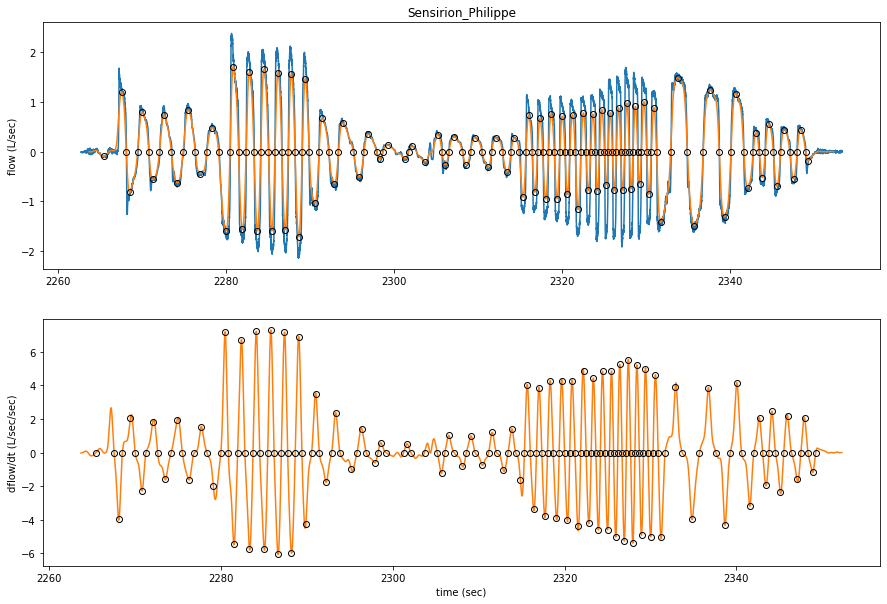

In [391]:
centers, intercept, slope = smooth_derivative(first.times, first.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.05)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.05)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(first.times, first.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe-derivative.png")

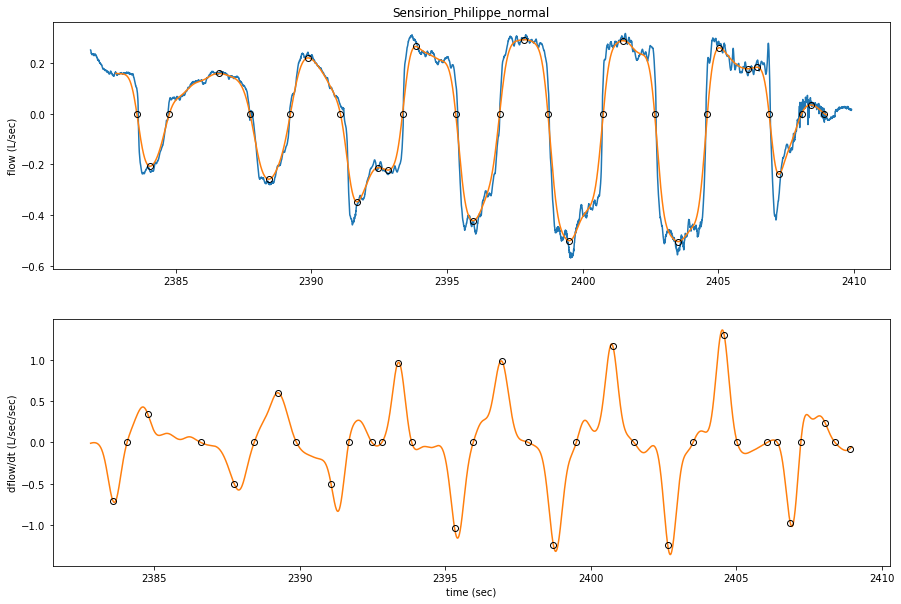

In [392]:
centers, intercept, slope = smooth_derivative(normal.times, normal.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.05)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.05)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(normal.times, normal.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe_normal")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe_normal-derivative.png")

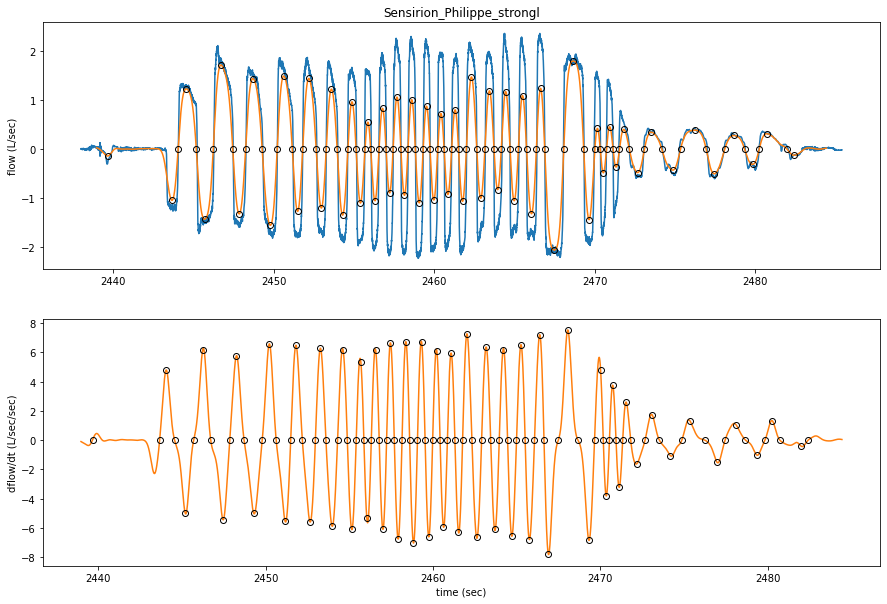

In [393]:
centers, intercept, slope = smooth_derivative(strong.times, strong.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.05)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.05)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(strong.times, strong.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe_strongl")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe_strongl-derivative.png")